# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

## Due: Midnight on March 30 (with 2-hour grace period) and worth 25 points





### What We Will Do in This Milestone Assignment

1. You will convene your team (listed on Blackboard) and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. The team leader should upload the notebook and then create a group on GS for the group submission.
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  

### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors. Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values. 

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


In [85]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
import kagglehub
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Download the Zillow Housing Dataset 

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.** 

For a detailed description of the dataset features, please refer to  **Appendix 1** below. 

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split. 

In [86]:

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

# df.to_csv("zillow_dataset_cleaned.csv", index=False)


File already exists. Skipping download.


## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data; 
- Create a regression model;
- Give a presentation to the marketing team about your results.  

#### **1 Discussion:** 

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)


**1.1:**  What is the objective of this project in business terms?

The objective is to develop a predictive model that estimates the assessed tax value (taxvaluedollarcnt) of residential properties. This will help Zillow improve its automated property valuation system, increase pricing transparency in the market, and support better decision-making for homeowners, buyers, and real estate professionals.

**1.2:**  How will your solution be used?

The predictive model will be incorporated into Zillow’s platform to help different users make better decisions. Homeowners can use it to estimate their property’s tax-assessed value and compare it to market prices. Buyers can check whether a home is fairly priced. Real estate investors can analyze valuation trends to identify potential opportunities. Internally, Zillow’s teams can use the model’s insights to refine pricing strategies and tax-related assessments.

Additionally, the model may help flag inconsistencies or outliers in tax valuations, bringing attention to properties that need further review.


**1.3:**  How should success (or failure) be measured?

The success of this model will be determined by how accurately and consistently it predicts assessed tax values. Key performance metrics include Root Mean Squared Error (RMSE), which measures the average size of prediction errors, Mean Absolute Error (MAE), which shows how far predictions typically deviate from actual values, and R2 (R-squared) Score, which indicates how well the model explains variations in tax values.

Beyond that, business success can be evaluated in several ways. One key factor is whether Zillow’s property valuation estimates improve. Another is a reduction in pricing discrepancies between assessed tax values and market prices. Additionally, positive feedback and increased adoption from homeowners, buyers, and real estate professionals will indicate the model’s effectiveness. If the model fails to provide meaningful improvements over existing methods, it may be necessary to adjust features, incorporate new data sources, or explore different modeling approaches to enhance its accuracy and reliability.

## Part 2: Download and perform preliminary exploration of the data [4 pts]

### Part 2.A: Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process. 
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

In [87]:
df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,assessmentyear,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
0,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,...,NaN,NaN,1998.0,NaN,NaN,2016.0,NaN,NaN,6.059063e+13,1023282.0
1,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,NaN,NaN,1967.0,1.0,NaN,2016.0,NaN,NaN,6.111001e+13,464000.0
2,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,NaN,NaN,1962.0,1.0,NaN,2016.0,NaN,NaN,6.059022e+13,564778.0
3,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1970.0,NaN,NaN,2016.0,NaN,NaN,6.037300e+13,145143.0
4,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1964.0,NaN,NaN,2016.0,NaN,NaN,6.037124e+13,119407.0


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          73923 non-null  float64
 13  f

In [89]:
df.nunique()

parcelid                        77414
airconditioningtypeid               5
architecturalstyletypeid            5
basementsqft                       43
bathroomcnt                        22
bedroomcnt                         16
buildingclasstypeid                 2
buildingqualitytypeid              12
calculatedbathnbr                  21
decktypeid                          1
finishedfloor1squarefeet         1787
calculatedfinishedsquarefeet     4972
finishedsquarefeet12             4868
finishedsquarefeet13               13
finishedsquarefeet15             1724
finishedsquarefeet50             1807
finishedsquarefeet6               350
fips                                3
fireplacecnt                        5
fullbathcnt                        13
garagecarcnt                       14
garagetotalsqft                   839
hashottuborspa                      1
heatingorsystemtypeid              10
latitude                        64038
longitude                       62461
lotsizesquar

In [90]:
# % missing vals
missing_percent = df.isnull().sum() / len(df) * 100

print(missing_percent)


parcelid                         0.000000
airconditioningtypeid           67.779882
architecturalstyletypeid        99.733292
basementsqft                    99.935578
bathroomcnt                      0.043807
bedroomcnt                       0.043807
buildingclasstypeid             99.980673
buildingqualitytypeid           35.823895
calculatedbathnbr                0.837489
decktypeid                      99.208895
finishedfloor1squarefeet        92.221664
calculatedfinishedsquarefeet     0.302784
finishedsquarefeet12             4.754358
finishedsquarefeet13            99.945885
finishedsquarefeet15            96.099880
finishedsquarefeet50            92.221664
finishedsquarefeet6             99.502661
fips                             0.043807
fireplacecnt                    89.320088
fullbathcnt                      0.837489
garagecarcnt                    67.118910
garagetotalsqft                 67.118910
hashottuborspa                  98.017085
heatingorsystemtypeid           36

In [91]:
feature_summary = pd.DataFrame({
    "Feature Name": df.columns,
    "Data Type": df.dtypes.values,
    "Unique Values": df.nunique().values,
    "Missing %": (df.isnull().sum() / len(df) * 100).round(2)
})


# https://pandas.pydata.org/docs/user_guide/categorical.html
# Empty list for categorical cols
cat_list = []
# Values to determine category or not
cat_threshold = 20


for i, row in feature_summary.iterrows():
    if row["Data Type"] == "object":
        cat_list.append("Categorical")  
    elif row["Unique Values"] <= cat_threshold:
        cat_list.append("Categorical") 
    else:
        cat_list.append("Numerical")  

feature_summary["Category"] = cat_list
print(feature_summary)


                                              Feature Name Data Type  \
parcelid                                          parcelid     int64   
airconditioningtypeid                airconditioningtypeid   float64   
architecturalstyletypeid          architecturalstyletypeid   float64   
basementsqft                                  basementsqft   float64   
bathroomcnt                                    bathroomcnt   float64   
bedroomcnt                                      bedroomcnt   float64   
buildingclasstypeid                    buildingclasstypeid   float64   
buildingqualitytypeid                buildingqualitytypeid   float64   
calculatedbathnbr                        calculatedbathnbr   float64   
decktypeid                                      decktypeid   float64   
finishedfloor1squarefeet          finishedfloor1squarefeet   float64   
calculatedfinishedsquarefeet  calculatedfinishedsquarefeet   float64   
finishedsquarefeet12                  finishedsquarefeet12   flo

In [92]:
max_value = df["taxvaluedollarcnt"].max()
print("Max tax value:", max_value)


Max tax value: 49061236.0


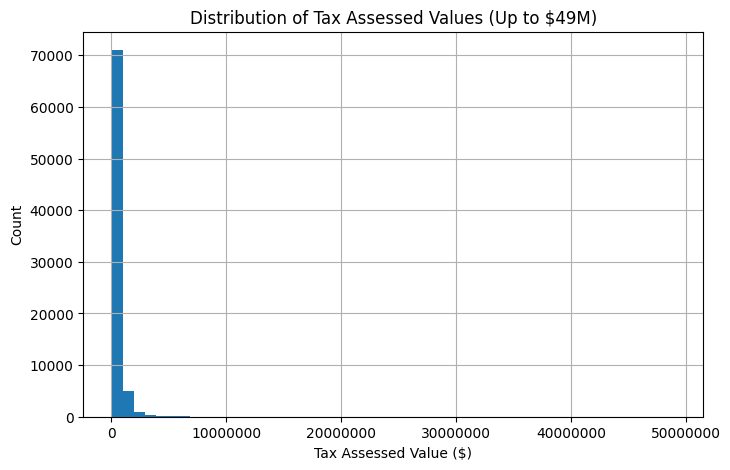

In [93]:
upper_limit = max_value
filtered_df = df[df["taxvaluedollarcnt"] <= upper_limit]

plt.figure(figsize=(8, 5))
filtered_df["taxvaluedollarcnt"].hist(bins=50)

plt.xlabel("Tax Assessed Value ($)")
plt.ylabel("Count")
plt.title("Distribution of Tax Assessed Values (Up to $49M)")
plt.ticklabel_format(style='plain', axis='x')
plt.show()


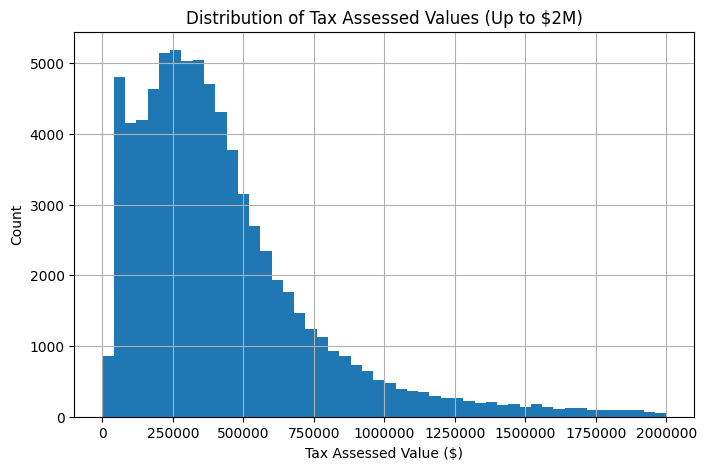

In [94]:
# More realistic view
upper_limit = 2000000  
filtered_df = df[df["taxvaluedollarcnt"] <= upper_limit]
plt.figure(figsize=(8, 5))
filtered_df["taxvaluedollarcnt"].hist(bins=50)

plt.xlabel("Tax Assessed Value ($)")
plt.ylabel("Count")
plt.title("Distribution of Tax Assessed Values (Up to $2M)")
plt.ticklabel_format(style='plain', axis='x')  
plt.show()


In [95]:
categorical_features = feature_summary.loc[feature_summary["Category"] == "Categorical", "Feature Name"].tolist()

print(*categorical_features, sep="\n")


airconditioningtypeid
architecturalstyletypeid
bedroomcnt
buildingclasstypeid
buildingqualitytypeid
decktypeid
finishedsquarefeet13
fips
fireplacecnt
fullbathcnt
garagecarcnt
hashottuborspa
heatingorsystemtypeid
poolcnt
pooltypeid10
pooltypeid2
pooltypeid7
propertycountylandusecode
propertylandusetypeid
propertyzoningdesc
regionidcounty
roomcnt
storytypeid
threequarterbathnbr
typeconstructiontypeid
unitcnt
numberofstories
fireplaceflag
assessmentyear
taxdelinquencyflag
taxdelinquencyyear


#### **2.A Discussion:** Answer the following questions.

**2.A.1:**  Which features are categorical?
- airconditioningtypeid  
- architecturalstyletypeid  
- bedroomcnt  
- buildingclasstypeid  
- buildingqualitytypeid  
- decktypeid  
- finishedsquarefeet13  
- fips  
- fireplacecnt  
- fullbathcnt  
- garagecarcnt  
- hashottuborspa  
- heatingorsystemtypeid  
- poolcnt  
- pooltypeid10  
- pooltypeid2  
- pooltypeid7  
- propertycountylandusecode  
- propertylandusetypeid  
- propertyzoningdesc  
- regionidcounty  
- roomcnt  
- storytypeid  
- threequarterbathnbr  
- typeconstructiontypeid  
- unitcnt  
- numberofstories  
- fireplaceflag  
- assessmentyear  
- taxdelinquencyflag  
- taxdelinquencyyear  

**2.A.2:**  Are there any features which appear at first glance to be **useless** for the business purpose of this project and should be deleted?  Give examples and describe your reasoning briefly. 

Some features do not seem relevant for predicting taxvaluedollarcnt based on business reasoning:

- parcelid – A unique property identifier, necessary for tracking but has no impact on tax valuation.  
- assessmentyear – Only contains one value (2016), meaning it does not affect property valuation.  
- taxdelinquencyflag and taxdelinquencyyear – These indicate unpaid taxes but do not directly influence assessed tax value.  
- rawcensustractandblock and censustractandblock – Detailed geographic codes that do not contribute to valuation beyond region-based features like regionidzip.  
- fireplaceflag – Indicates whether a fireplace exists but does not quantify its impact on valuation.  
- yardbuildingsqft17 and yardbuildingsqft26 – Represent small yard structures that likely have minimal influence on assessed value.


**2.A.3:**  Are there any features which appear to be **useless** because of the percentage of missing values?  If so, give an example. 


- buildingclasstypeid – Missing in 99.98% of rows, meaning almost no data is available.  
- basementsqft – Missing in 99.94% of rows, making it nearly useless for most properties.  
- storytypeid – Missing in 99.94% of rows, suggesting it is rarely recorded.  
- finishedsquarefeet13 – Missing in 99.95% of rows, meaning it is not commonly tracked.  
- yardbuildingsqft26 – Missing in 99.91% of rows, making it unreliable for analysis.  
- pooltypeid10, pooltypeid2, pooltypeid7 – Each missing in 80–99% of rows, suggesting they might be too spare to provide insight.
- fireplaceflag – Missing in 99.78% of rows, making it unreliable for prediction.  
- taxdelinquencyflag and taxdelinquencyyear – Missing in 96.26% of rows, suggesting limited usefulness for tax valuation. 

**2.A.4:**  Are there any features which appear to be **useless** because of the number of unique values?  If so, give an example. 

- parcelid – A unique identifier for each property, meaning it has nearly as many unique values as rows. Since it does not provide predictive value, it should be excluded from model training.  
- rawcensustractandblock and censustractandblock – Highly detailed geographic identifiers with thousands of unique values. Other location-based features like regionidzip or regionidcity may already capture useful geographic information, making these redundant.  
- latitude and longitude – Nearly unique for every property. While useful for mapping, these features should not be included in a standard regression model.  
- taxvaluedollarcnt – The target variable itself, which is continuous and should not be treated as a categorical predictor.  

### Part 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  

- To get an overview, generate histograms for all features using `df.hist()`  (Hint: increase the figsize and set the layout to `(-1,m)` to get  `m` columns and as many rows as necessary.)
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

In [96]:
numerical_features = df.select_dtypes(include=["number"]).columns.tolist()

df[numerical_features].hist(
    figsize=(24, len(numerical_features) * 5),  
    bins=50,
    layout=(-1, 2), 
    edgecolor='black'
)

plt.tight_layout()
plt.show()



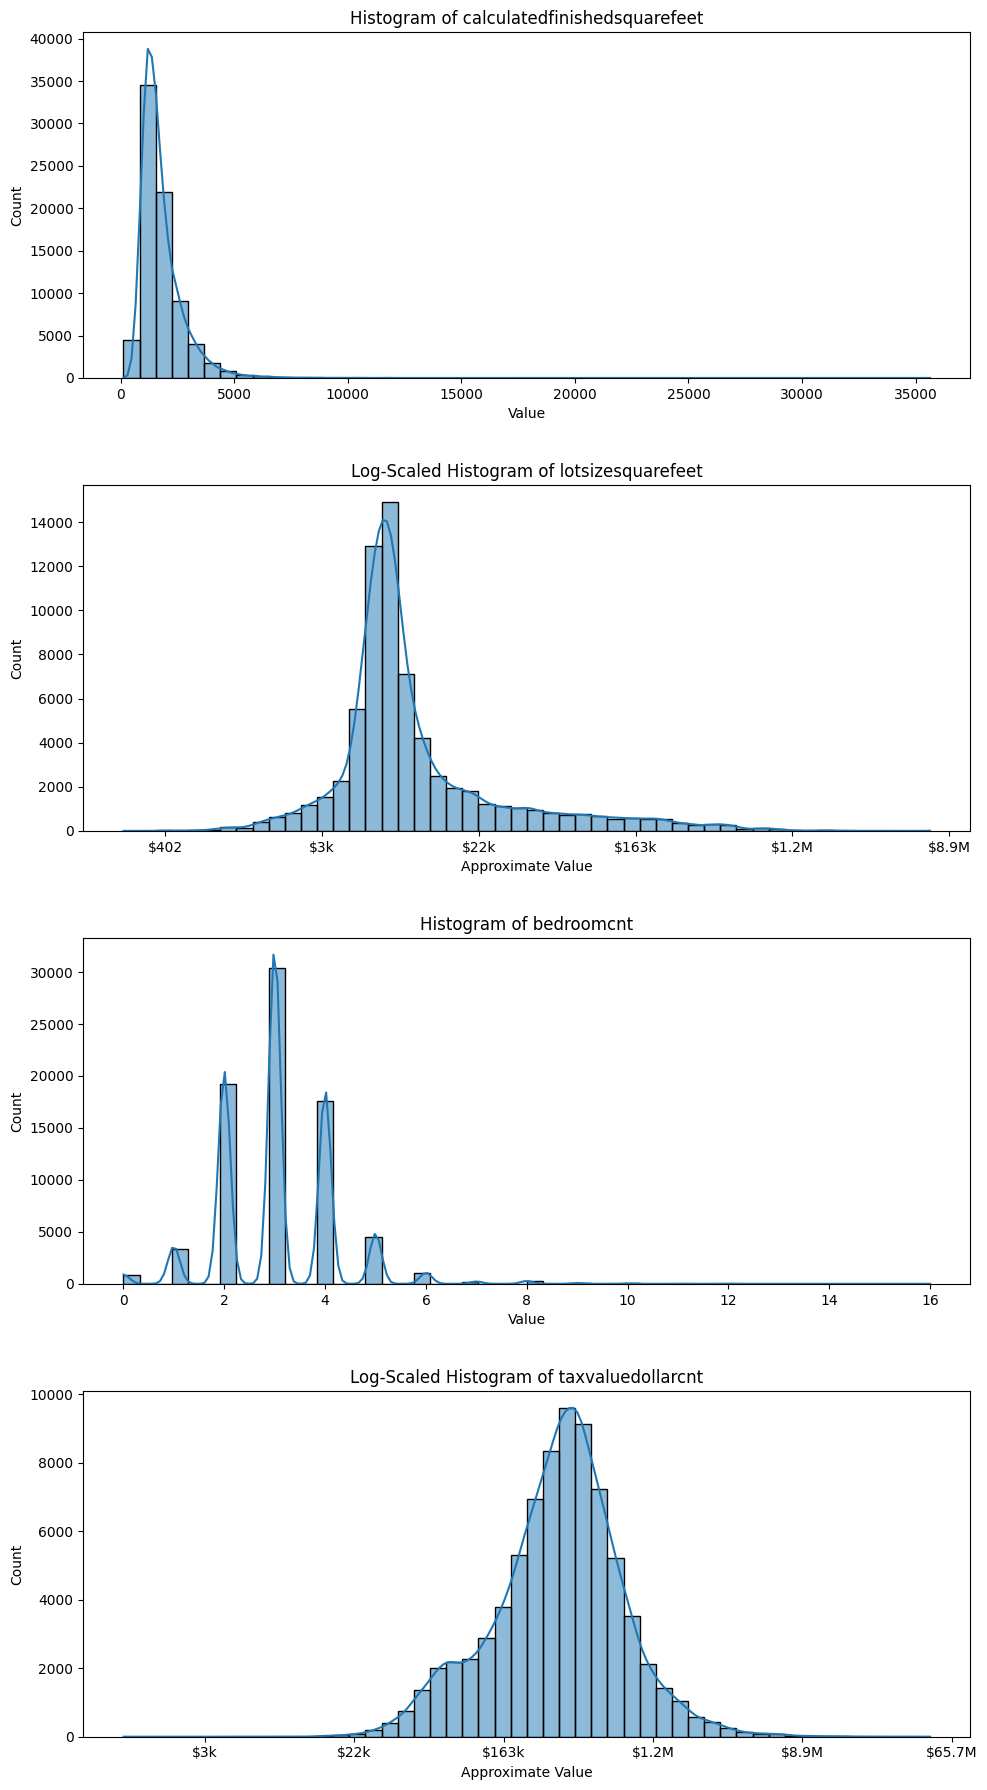

In [97]:
# Selecting three specific features I think will have the most impact

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

def log_to_dollars(x, pos):
    value = np.expm1(x)
    if value >= 1_000_000:
        return f"${value/1_000_000:.1f}M"
    elif value >= 1_000:
        return f"${value/1_000:.0f}k"
    else:
        return f"${int(value)}"

selected_features = ["calculatedfinishedsquarefeet", "lotsizesquarefeet", "bedroomcnt", "taxvaluedollarcnt"]
fig, axes = plt.subplots(len(selected_features), 1, figsize=(10, 18))

for i, feature in enumerate(selected_features):
    data = df[feature].dropna()

    if feature in ["lotsizesquarefeet", "taxvaluedollarcnt"]:
        data = data[data > 0]
        data = np.log1p(data)
        axes[i].set_title(f"Log-Scaled Histogram of {feature}")
        axes[i].set_xlabel("Approximate Value")
        axes[i].xaxis.set_major_formatter(FuncFormatter(log_to_dollars))
    else:
        axes[i].set_title(f"Histogram of {feature}")
        axes[i].set_xlabel("Value")

    sns.histplot(data, bins=50, kde=True, ax=axes[i])
    axes[i].set_ylabel("Count")

plt.tight_layout(h_pad=3)
plt.show()




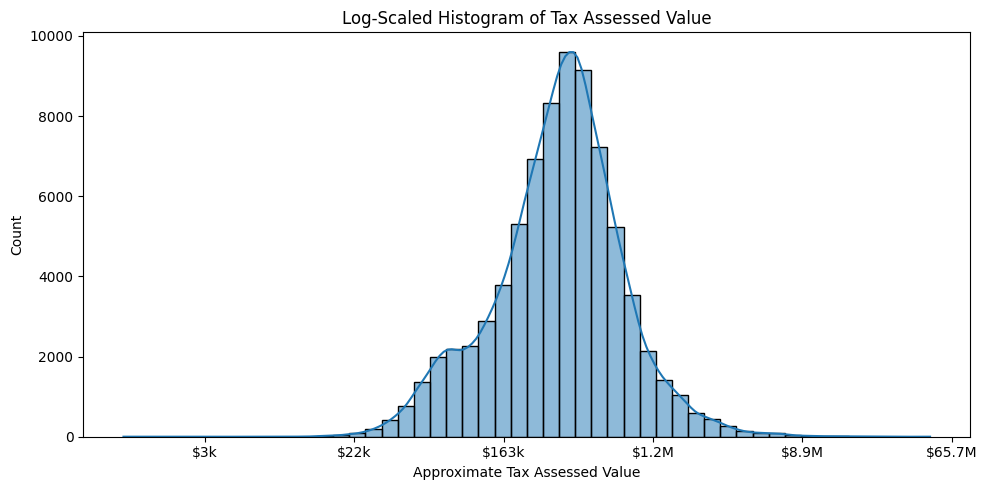

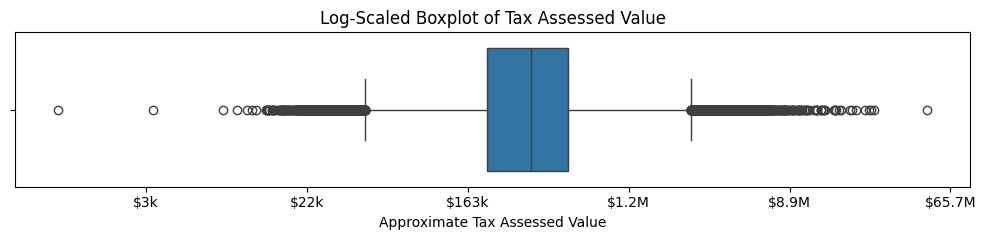

In [98]:
target = df['taxvaluedollarcnt'].dropna()
target = target[target > 0]
log_target = np.log1p(target)

# Function to convert log values back to readable dollar amounts
def log_to_dollars(x, pos):
    value = np.expm1(x)
    if value >= 1_000_000:
        return f"${value/1_000_000:.1f}M"
    elif value >= 1_000:
        return f"${value/1_000:.0f}k"
    else:
        return f"${int(value)}"

# Histogram 
plt.figure(figsize=(10, 5))
sns.histplot(log_target, bins=50, kde=True)
plt.title("Log-Scaled Histogram of Tax Assessed Value")
plt.xlabel("Approximate Tax Assessed Value")
plt.ylabel("Count")
plt.gca().xaxis.set_major_formatter(FuncFormatter(log_to_dollars))
plt.tight_layout()
plt.show()

# Boxplot 
plt.figure(figsize=(10, 2.5))
sns.boxplot(x=log_target, orient='h')
plt.title("Log-Scaled Boxplot of Tax Assessed Value")
plt.xlabel("Approximate Tax Assessed Value")
plt.gca().xaxis.set_major_formatter(FuncFormatter(log_to_dollars))
plt.tight_layout()
plt.show()




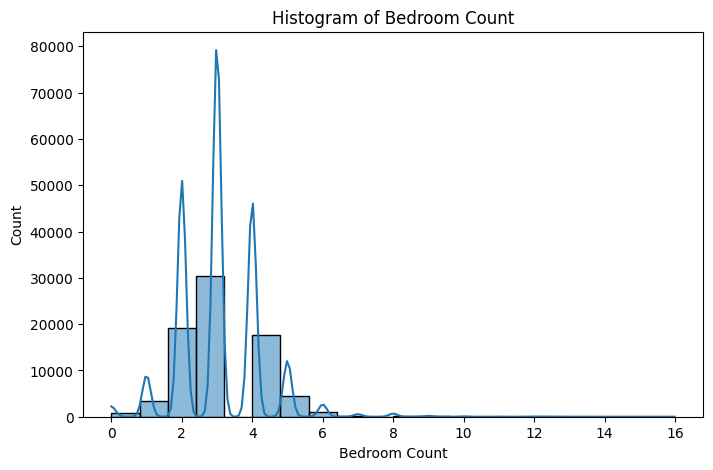

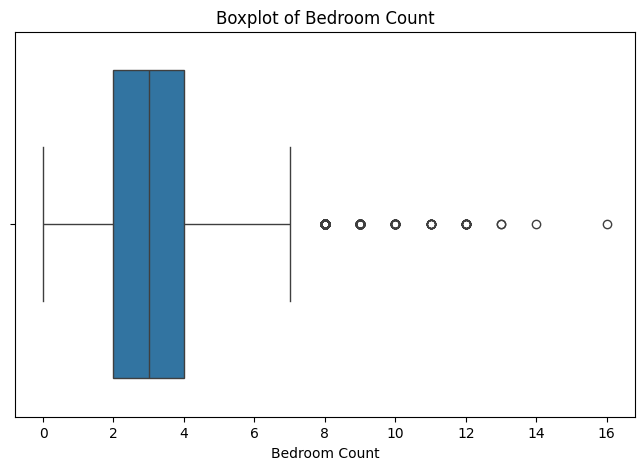

In [99]:
# Histogram for bedroomcnt
plt.figure(figsize=(8, 5))
sns.histplot(df['bedroomcnt'].dropna(), bins=20, kde=True)
plt.title("Histogram of Bedroom Count")
plt.xlabel("Bedroom Count")
plt.ylabel("Count")
plt.show()

# Boxplot for bedroomcnt 
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['bedroomcnt'].dropna())
plt.title("Boxplot of Bedroom Count")
plt.xlabel("Bedroom Count")
plt.show()


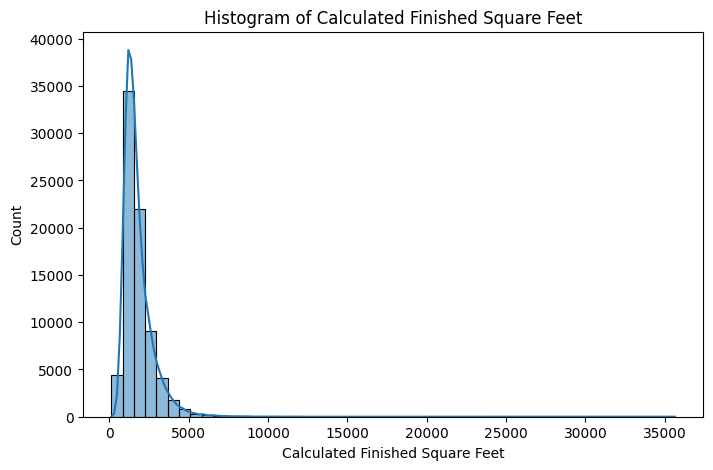

NameError: name 'do' is not defined

In [100]:
# Histogram for calculatedfinishedsquarefeet
plt.figure(figsize=(8, 5))
sns.histplot(df['calculatedfinishedsquarefeet'].dropna(), bins=50, kde=True)
plt.title("Histogram of Calculated Finished Square Feet")
plt.xlabel("Calculated Finished Square Feet")
plt.ylabel("Count")
plt.show()
do 
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['calculatedfinishedsquarefeet'].dropna())
plt.title("Boxplot of Calculated Finished Square Feet")
plt.xlabel("Calculated Finished Square Feet")
plt.show()


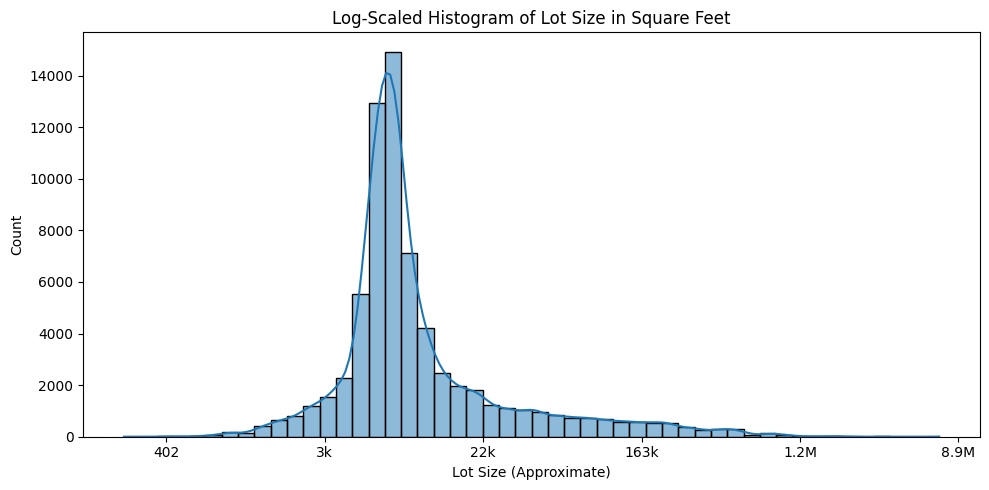

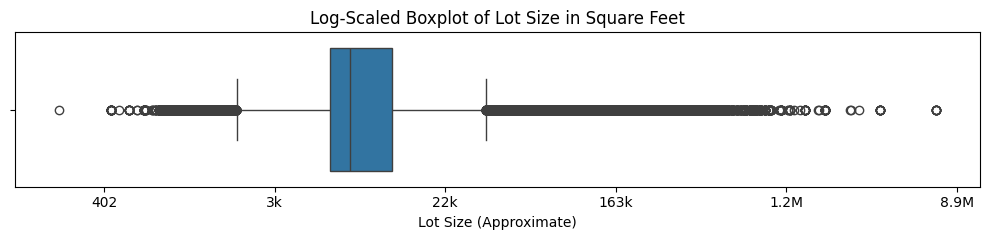

In [ ]:
def format_sqft(x, pos):
    value = np.expm1(x)
    if value >= 1_000_000:
        return f"{value/1_000_000:.1f}M"
    elif value >= 1_000:
        return f"{value/1_000:.0f}k"
    else:
        return f"{int(value)}"

# Prepare and log-transform the data
lot_sizes = df['lotsizesquarefeet'].dropna()
lot_sizes = lot_sizes[lot_sizes > 0]
log_lot_sizes = np.log1p(lot_sizes)

# Histogram (log-scaled)
plt.figure(figsize=(10, 5))
sns.histplot(log_lot_sizes, bins=50, kde=True)
plt.title("Log-Scaled Histogram of Lot Size in Square Feet")
plt.xlabel("Lot Size (Approximate)")
plt.ylabel("Count")
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_sqft))
plt.tight_layout()
plt.show()

# Boxplot (log-scaled)
plt.figure(figsize=(10, 2.5))
sns.boxplot(x=log_lot_sizes, orient='h')
plt.title("Log-Scaled Boxplot of Lot Size in Square Feet")
plt.xlabel("Lot Size (Approximate)")
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_sqft))
plt.tight_layout()
plt.show()

#### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:
- What is the distribution (normal, exponential, etc.) if any?
- Any problems (e.g., outliers, any odd characteristics)?
- Anything else interesting? Why did you choose it?


For this part of the analysis, I looked closely at four features: taxvaluedollarcnt, lotsizesquarefeet, calculatedfinishedsquarefeet, and bedroomcnt. None of them followed a normal distribution. Taxvaluedollarcnt was heavily right-skewed, with most values clustered on the lower end and a small number of extremely high-value properties that stretched the scale. Lotsizesquarefeet had a similar issue—while most lots were fairly small, a few were huge, which made the histogram hard to read without a log transformation. Calculatedfinishedsquarefeet was also right-skewed, but the distribution was still readable without transformation, and it showed that most homes fall between 1,000 and 3,000 square feet. Bedroomcnt was more discrete and showed clear peaks at 2, 3, and 4 bedrooms, which makes sense for typical homes. There were some outliers with very high bedroom counts, but they were rare. I chose these features because they seemed closely related to property value and offered a mix of continuous and discrete variables, which made the analysis more interesting.

## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts]



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here]

### Part 3.A: Drop features you judge to be unsuitable for the regression task

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task! 

In [ ]:
# Make a copy of the original dataset to use for the regression task
df_regression = df.copy()

columns_to_remove = [
    'parcelid',
    'rawcensustractandblock',
    'censustractandblock',
    'propertyzoningdesc',
    'propertycountylandusecode',
    'fireplaceflag',
    'assessmentyear'
]

# Drop the features from the new dataset
df_regression.drop(columns=columns_to_remove, inplace=True)

#### **3.A Discussion:** Justify in a paragraph your decisions about which features to drop. 
- parcelid: This is just a unique identifier for each property, so it doesn’t have any predictive value for the regression model.

- rawcensustractandblock and censustractandblock: These are geographic codes that aren’t easy to interpret or use without additional mapping data, so they’re not helpful in their raw form.

- propertyzoningdesc and propertycountylandusecode: These are text-based codes that would require a lot of preprocessing or domain knowledge to make useful, so I chose to drop them for now.

- fireplaceflag: This column only tells us whether a fireplace exists, which is already captured in more detail by the fireplacecnt feature.

- assessmentyear: Every row has the same year, so it doesn’t offer any variation that would help the model learn patterns.

### Part 3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully. 

In [ ]:
df_regression.columns

Index(['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft',
       'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertylandusetypeid', 'regionidcity', 'regionidcounty',
       'regionidneighborhood', 'regionidzip', 'roomcnt', 'storytypeid',
       'threequarterbathnbr', 'typeconstructiontypeid', 'unitcnt',
       'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt',
       'numberofstories', 'taxdelinquencyflag', 'taxdelinquencyyear',
   

In [ ]:
null_percent = (df_regression.isnull().sum() / len(df_regression) * 100).round(2)

# > 95% null
too_many_nulls = null_percent[null_percent > 95]
print("Features with \"too many\" nulls (>95%):\n")
print(too_many_nulls)


Features with "too many" nulls (>95%):

architecturalstyletypeid    99.73
basementsqft                99.94
buildingclasstypeid         99.98
decktypeid                  99.21
finishedsquarefeet13        99.95
finishedsquarefeet15        96.10
finishedsquarefeet6         99.50
hashottuborspa              98.02
poolsizesum                 98.88
pooltypeid10                99.40
pooltypeid2                 98.62
storytypeid                 99.94
typeconstructiontypeid      99.71
yardbuildingsqft17          96.92
yardbuildingsqft26          99.91
taxdelinquencyflag          96.26
taxdelinquencyyear          96.26
dtype: float64


In [ ]:
df_modeling = df_regression.drop(columns=too_many_nulls.index.tolist())
print(f"\ndf_modeling created. New shape: {df_modeling.shape}")



df_modeling created. New shape: (77613, 31)


#### **3.B Discussion:** In a paragraph, explain your decision about which features were dropped
I dropped a handful of features that were missing in more than 95% of the rows. At that point, there just isn’t enough usable data to make those columns worth keeping. For example, columns like basementsqft and finishedsquarefeet13 only had values in a tiny fraction of the dataset. I didn’t think it made sense to try and fill in that many blanks, since it probably wouldn’t be reliable. Dropping those features felt like the cleaner option and helps keep the dataset focused on the columns that actually have enough data to work with.


### Part 3.C: Drop Problematic **samples** 

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values 
- It has a null value in the target
- It contains outliers, especially in the target



Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


In [ ]:
# Nulls in target col
df_modeling = df_modeling[df_modeling['taxvaluedollarcnt'].notnull()]

In [ ]:
# Drop rows missing key features
key_features = [
    'taxvaluedollarcnt',
    'calculatedfinishedsquarefeet',
    'bedroomcnt',
    'yearbuilt'
]

df_modeling_clean = df_modeling.dropna(subset=key_features)

# Show the number of rows removed
rows_removed = df_modeling.shape[0] - df_modeling_clean.shape[0]
print(f"Number of rows removed for missing key features: {rows_removed}")
print(f"New shape of cleaned dataset: {df_modeling_clean.shape}")


Number of rows removed for missing key features: 8
New shape of cleaned dataset: (7767, 31)


In [ ]:
# Removing outliers, 99th percentile of the target
upper_limit = df_modeling_clean['taxvaluedollarcnt'].quantile(0.99)

num_above_threshold = (df_modeling_clean['taxvaluedollarcnt'] > upper_limit).sum()
print("99th percentile value:", upper_limit)
print("Rows above this value:", num_above_threshold)
print("Shape before dropping:", df_modeling_clean.shape)

df_modeling_clean = df_modeling_clean[df_modeling_clean['taxvaluedollarcnt'] <= upper_limit]
print("Shape after dropping:", df_modeling_clean.shape)



99th percentile value: 3578718.78
Rows above this value: 78
Shape before dropping: (7767, 31)
Shape after dropping: (7689, 31)


#### **3.C Discussion:** In a short paragraph, explain your decision about which samples were dropped

I dropped any rows that were missing key information like the target variable (taxvaluedollarcnt), calculated square footage, bedroom count, or year built, since those are important features for modeling. I also removed a small number of extreme outliers in the target by dropping values above the 99th percentile. These properties were likely very high-end or unusual cases that could skew the model. The goal was to keep the dataset focused on typical, well-documented homes.


### Part 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

In [ ]:
missing_cols = df_modeling_clean.columns[df_modeling_clean.isnull().any()]
missing_summary = df_modeling_clean[missing_cols].isnull().sum().sort_values(ascending=False)

missing_summary

threequarterbathnbr         5591
finishedsquarefeet50        5477
finishedfloor1squarefeet    5477
fireplacecnt                4861
numberofstories             4549
garagetotalsqft             4534
garagecarcnt                4534
buildingqualitytypeid       3155
unitcnt                     3152
heatingorsystemtypeid       2853
airconditioningtypeid       2549
regionidneighborhood        2281
pooltypeid7                 1464
poolcnt                     1420
lotsizesquarefeet            107
regionidcity                   3
finishedsquarefeet12           2
dtype: int64

In [ ]:
# Impute missing vals based on methodology below:

# Fill 0 where missing means "none"
df_modeling_clean['threequarterbathnbr'] = df_modeling_clean['threequarterbathnbr'].fillna(0)
df_modeling_clean['fireplacecnt'] = df_modeling_clean['fireplacecnt'].fillna(0)
df_modeling_clean['pooltypeid7'] = df_modeling_clean['pooltypeid7'].fillna(0)
df_modeling_clean['poolcnt'] = df_modeling_clean['poolcnt'].fillna(0)
df_modeling_clean['garagecarcnt'] = df_modeling_clean['garagecarcnt'].fillna(0)
df_modeling_clean['garagetotalsqft'] = df_modeling_clean['garagetotalsqft'].fillna(0)

# Fill median for selected numerical features
for col in [
    'finishedfloor1squarefeet', 'finishedsquarefeet50', 'numberofstories',
    'unitcnt', 'finishedsquarefeet12', 'fullbathcnt', 'calculatedbathnbr',
    'lotsizesquarefeet'  # added here
]:
    median_value = df_modeling_clean[col].median()
    df_modeling_clean[col] = df_modeling_clean[col].fillna(median_value)

# Fill mode for selected categorical features
for col in [
    'airconditioningtypeid', 'heatingorsystemtypeid', 
    'buildingqualitytypeid', 'regionidcity', 'regionidzip'
]:
    mode_value = df_modeling_clean[col].mode().iloc[0]
    df_modeling_clean[col] = df_modeling_clean[col].fillna(mode_value)

# Fill 'Unknown' for regionidneighborhood
df_modeling_clean['regionidneighborhood'] = df_modeling_clean['regionidneighborhood'].astype('str').fillna("Unknown")

# Final check
df_modeling_clean.isnull().sum().sort_values(ascending=False).head(10)


airconditioningtypeid           0
bathroomcnt                     0
bedroomcnt                      0
buildingqualitytypeid           0
calculatedbathnbr               0
finishedfloor1squarefeet        0
calculatedfinishedsquarefeet    0
finishedsquarefeet12            0
finishedsquarefeet50            0
fips                            0
dtype: int64

In [ ]:
df_modeling_clean.isnull().sum().sort_values(ascending=False).head(20)


airconditioningtypeid           0
bathroomcnt                     0
bedroomcnt                      0
buildingqualitytypeid           0
calculatedbathnbr               0
finishedfloor1squarefeet        0
calculatedfinishedsquarefeet    0
finishedsquarefeet12            0
finishedsquarefeet50            0
fips                            0
fireplacecnt                    0
fullbathcnt                     0
garagecarcnt                    0
garagetotalsqft                 0
heatingorsystemtypeid           0
latitude                        0
longitude                       0
lotsizesquarefeet               0
poolcnt                         0
pooltypeid7                     0
dtype: int64

In [ ]:
df_modeling_clean.columns

Index(['airconditioningtypeid', 'bathroomcnt', 'bedroomcnt',
       'buildingqualitytypeid', 'calculatedbathnbr',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet50', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'pooltypeid7', 'propertylandusetypeid', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'threequarterbathnbr', 'unitcnt', 'yearbuilt', 'numberofstories',
       'taxvaluedollarcnt'],
      dtype='object')

#### **3.D Discussion:**  Describe in a paragraph your decisions about which methods you used to impute missing values in the dataset

To handle the rest of the missing values, I used different approaches depending on what made the most sense for each column. If the missing value likely meant “none,” like with fireplacecnt or poolcnt, I just filled in 0. For columns like lotsizesquarefeet that had a lot of variation and some big outliers, I went with the median. For a few categorical columns, like airconditioningtypeid and regionidzip, I filled in the most common value. And for regionidneighborhood, I used "Unknown" since not having that info might actually be meaningful. The goal was to keep as much data as possible without making weird assumptions.

### 3.E: Encode the Categorical Features (if any)

You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary. 

In [ ]:
categorical_cols = df_modeling_clean.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns to encode:", categorical_cols)


Categorical columns to encode: ['regionidneighborhood']


In [ ]:
# One-hot encode regionidneighborhood
df_encoded = pd.get_dummies(df_modeling_clean, columns=categorical_cols, drop_first=True)


In [ ]:
print("Final shape after encoding:", df_encoded.shape)


Final shape after encoding: (7689, 299)


## Part 4:  Investigate Feature Relationships  [6 pts]

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project. 

### Part 4.A:

   - Compute and analyze pairwise correlations using a correlation matrix.
   - Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well). 
   - Identify features with strong correlations or notable relationships that may impact model performance.
   - Investigate forward and backward feature selection
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

Your code below, in multiple cells with descriptive comments. 

#### **4.A Discussion:**  Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships. 
 How do the different methods for seeing relationships compare? Do they agree or disagree?



### Part 4.B:  2-Dimensional Visualizations for Interesting Patterns  
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis. 
   - Create 2D scatter plots or density plots to explore interactions between these features.  
   - Provide brief interpretations of any observed patterns or trends. 

#### **4.B Discussion:** Provide brief interpretations of any observed patterns or trends.


## Part 5:  Feature Engineering: Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]

**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset. 
- Understand that you can't evaluate the final usefulness of these transformations
until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection). 
- Therefore, write your transformations as functions or otherwise be prepared
to choose later on which transformations may be necessary. 

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary
- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).
- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question. 

#### **5 Discussion:** Describe in a paragraph why you chose these transformations and what you observed. 


## **Appendix 1: Features of the Zillow Dataset**  

0. **parcelid**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. **architecturalstyletypeid**: Identifier for the architectural style of the property.  
3. **basementsqft**: Square footage of the basement.  
4. **bathroomcnt**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. **buildingqualitytypeid**: Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **finishedfloor1squarefeet**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **finishedsquarefeet13**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **finishedsquarefeet6**: Base unfinished and finished area square footage.  
17. **fips**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **fullbathcnt**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **latitude**: Latitude coordinate of the property.  
25. **longitude**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **pooltypeid10**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **rawcensustractandblock**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **storytypeid**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **threequarterbathnbr**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **assessmentyear**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **taxdelinquencyyear**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## Appendix 2: Summary of Basic Imputation Methods
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |

